## (2) Thompson Sampling for Multi-Armed Bandits

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma

from itertools import permutations 
from scipy.stats import beta


### (2a) Beta distributions to model uncertainty about probabilities
Consider a bandit that for each pull of an arm, produces a binary reward: $r = 1$ (with probability $p$) or $r = 0$ (with probability $1 − p$).

Assuming the bandit has $K$ arms, this means that there are $K$ unknown probabilities $p_1, p_2, . . . , p_K$ and we need to identify the arm that has the highest probability:

$$
p_∗ = \operatorname{ max }{p_{1},p_{2},...,p_{K}},
$$

as pulling this arm will result in the highest cumulative reward.

**Using the beta-distribution to model the uncertainty on a probability**. Initially we have no information (total uncertainty) about the values of the probabilities, but each pull of an arm yields a binary outcome (reward), providing some information about the underlying probability, and thus reducing the corresponding uncertainty.

We model our uncertainty about the actual (but unknown) value $p$ using a [[beta distribution]]. This is a (unimodal) probability distribution on the interval $[0, 1]$ which depends on two parameters: $\alpha, \beta \geq 1$. The explicit distribution is given by (for $\alpha$, $\beta$ integers!):

$$
B(x;\alpha,\beta)= \frac{(\alpha+\beta−1)!}{(\alpha − 1)! (\beta − 1)!} x^{α−1}(1−x)^{\beta−1}
$$
for $0 \leq x \leq 1$.

The parameters $\alpha$ and $\beta$ determine the shape of the distribution:

**(1)** If $\alpha = \beta = 1$ then we have the uniform distribution.

**(2)** If $\alpha = \beta$ the distribution is symmetric about $x = \frac{1}{2}$.

**(3)** If $\alpha > \beta$ the density is right-leaning (i.e., concentrated in the neighbourhood of $1$). In fact, one can compute the mean explicitly:
$$
X \sim B(x;\alpha,\beta) \implies EX= \frac{\alpha}{\alpha+\beta} = \frac{1}{1+\left( \frac{\beta}{\alpha} \right)}
$$
indicating that the ratio $\frac{\beta}{\alpha}$ determines the position of the mean.

**(4)** Larger values of α and β produce a more peaked distribution. This follows from the formula for the variance:
$$
X \sim B(x;\alpha,\beta) \implies \operatorname{ Var }(X)= \frac{\alpha\beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)}
$$

In [5]:
class BETA:
    def __init__(self, alpha=1, beta=1):
        self.a = alpha
        self.b = beta
    
    # INTEGERS
    def compute_value(self, x):
        '''
        Calculating the value of the PDF of the Beta distribution at x, for the given a and b. 
        '''
        # Checks
        if not isinstance(self.a, int):
            raise ValueError("a must be an integer.")
        if not isinstance(self.b, int):
            raise ValueError("b must be an integer.")
        if not self.a >= 1:
            raise ValueError("a must be greater than or equal to 1.")
        if not self.b >= 1:
            raise ValueError("b must be greater than or equal to 1.")
        
        # Formula
        term1 = math.factorial(self.a + self.b-1)/(math.factorial(self.a - 1)*math.factorial(self.b - 1))
        term2 = x**(self.a - 1)
        term3 = (1-x)**(self.b - 1)
        f = term1*term2*term3

        # Return
        return f
    
    def distribution_int(self, num_points=100):
        # Generate x values
        x_values = np.linspace(0, 1, num_points)

        # Calculate the Beta distribution
        beta_values = [self.compute_value(x) for x in x_values]

        return beta_values
    
    def mean(self):
        return self.a / (self.a + self.b)

    def variance(self):
        return (self.a * self.b) / ((self.a + self.b)**2 * (self.a + self.b + 1))
    
    def thomson_update(self,reward):
        if reward==1:
            self.a += 1
        if reward==0:
            self.b += 1


In [3]:
def plot_beta_distributions(beta_objects, num_points=100):
    x_values = np.linspace(0, 1, num_points)
    df = pd.DataFrame({'x': x_values})

    # Prepare DataFrame with distributions
    for beta_obj in beta_objects:
        distribution = beta_obj.distribution_int(num_points)
        label = f'$\\alpha$={beta_obj.a}, $\\beta$={beta_obj.b}'
        df[label] = distribution

    # Reshape DataFrame for seaborn's lineplot
    df_melted = df.melt(id_vars='x', var_name='Parameters', value_name='Probability Density')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_melted, x='x', y='Probability Density', hue='Parameters', palette='viridis')

    # Customizing the plot
    if len(beta_objects) > 1:
        plt.title('Beta Distributions for Different $\\alpha$ and $\\beta$ Values \n Annotated: "Mean (Variance)')
    else:
        plt.title('Beta Distribution')

    plt.xlabel('x')
    plt.ylabel('Probability Density')
    sns.despine()

    # Annotate mean and variance
    for beta_obj in beta_objects:
        mean = beta_obj.mean()
        variance = beta_obj.variance()
        plt.annotate(
            f'{mean:.2f} ({variance:.3f})', 
            xy=(mean, beta_obj.compute_value(mean)), 
            xytext=(mean, beta_obj.compute_value(mean)+ 0.05),  # Adjust vertical offset
            fontsize=9, ha='center', va='bottom', font="Times"
        )

    plt.legend(title='Parameters')
    plt.show()

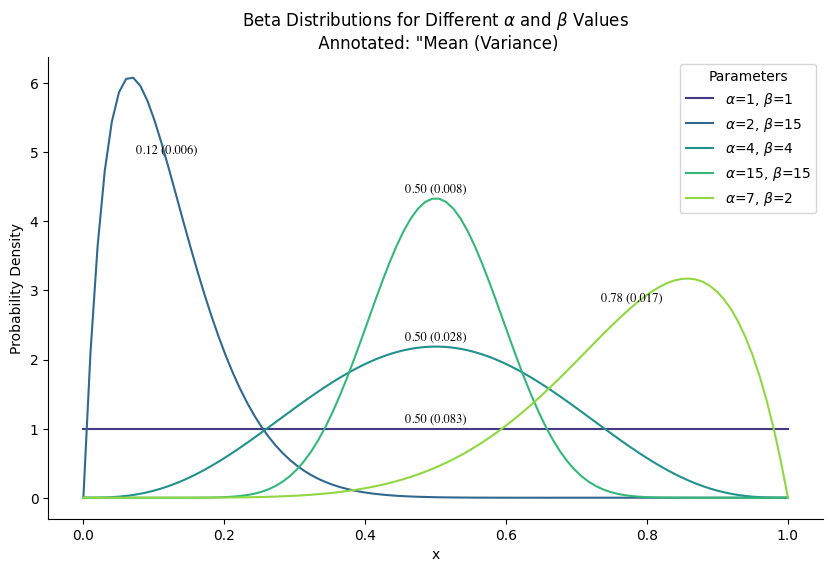

In [6]:
b1 = BETA()
b2 = BETA(2, 15)
b3 = BETA(4, 4)
b4 = BETA(15, 15)
b5 = BETA(7, 2)

plot_beta_distributions([b1, b2, b3, b4, b5])


### (2b) Thompson’s Bayesian update rule
Although the beta-distribution seems like a reasonable model to quantify the uncertainty on a probability, there is a deeper reason for its use. 

Updating a (prior) beta-density with binary observations, results in a new beta-density with updated parameters (this is an example of what is known as **conjugated priors**). Specifically, if the prior is modeled as $B(x, \alpha, \beta)$, and we observe $s$ successes (1) and $f$ failures (0) then the posterior would be the beta distribution $B(x; \alpha+s, \beta+f)$. This observation yields the rationale for Thompson’s Bayesian update rule:
1. Sample from the bandit and get reward $r$ (either $r = 1$ or $r = 0$).
2. Update the values for $\alpha$ and $\beta$ as follows:
	- if $r=1$, then $\alpha \leftarrow \alpha+1$
	- if $r=0$, then $\beta \leftarrow \beta+1$
- This update rule can be summarised as:
$$
\alpha \leftarrow \alpha+1 \quad \beta \leftarrow \beta+(1-r)
$$

**Task 1**: Implement the Thompson update rule for single arm bandit (i.e., $k = 1$) and show experimentally that the Beta-density increasingly peaks at the correct value for $p$. To this end, plot both the evolution of the mean and variance over (iteration)time.

In [18]:
def thompson_for_1_bandit(probability, # that it is true
                        n_iterations=10000):
    means = []
    variances = []

    # Initializing with a = 1, b = 1.
    BETA_dist = BETA()

    for i in range(n_iterations):
        # Simulate pulling the arm
        reward = np.random.binomial(1, probability)

        # Update alpha and beta in the BETA object
        BETA_dist.thomson_update(reward)

        # Calculating the new mean and variance
        means.append(BETA_dist.mean())
        variances.append(BETA_dist.variance())

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plotting the evolution of mean
    plt.subplot(1, 2, 1)
    plt.plot(means, label='Mean', color="green")
    plt.axhline(y=probability, color='black', linestyle='--', label='Underlying\nProbability')
    plt.title('Evolution of Mean')
    plt.xlabel('Iterations')
    plt.ylabel('Mean')
    plt.legend()

    # Plotting the evolution of variance
    plt.subplot(1, 2, 2)
    plt.plot(variances, label='Variance', color="purple")
    plt.title('Evolution of Variance')
    plt.xlabel('Iterations')
    plt.ylabel('Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()


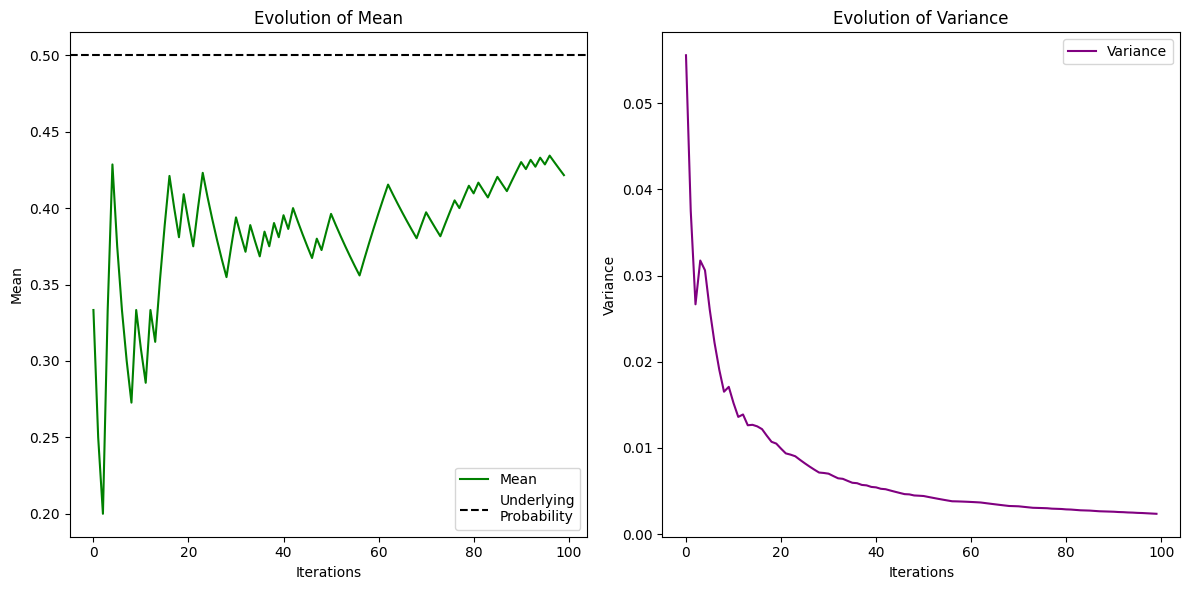

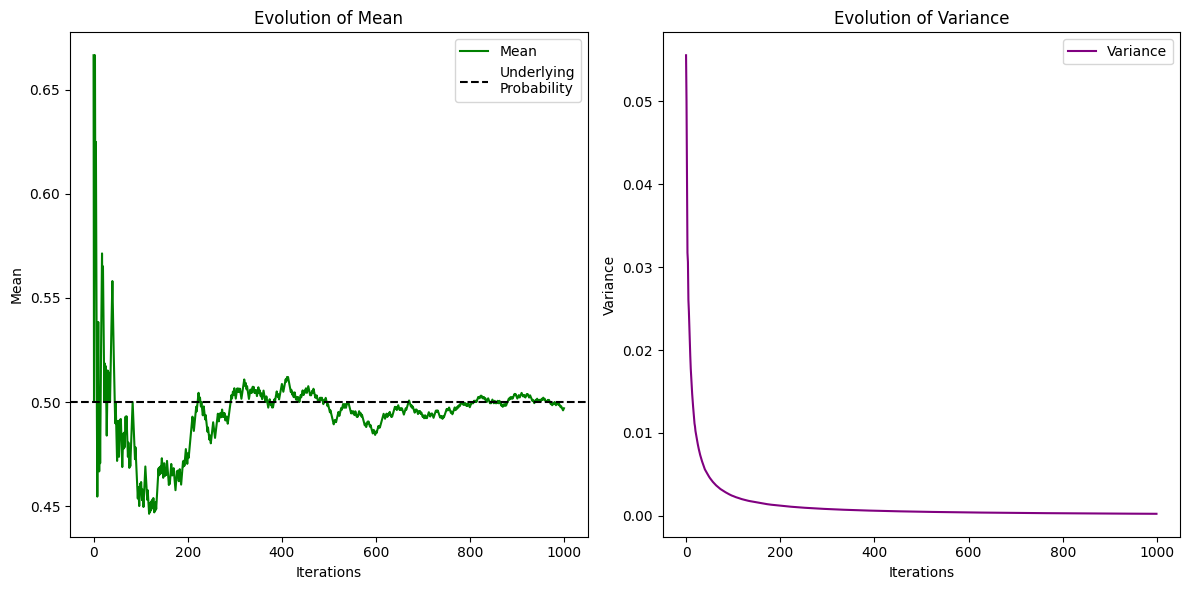

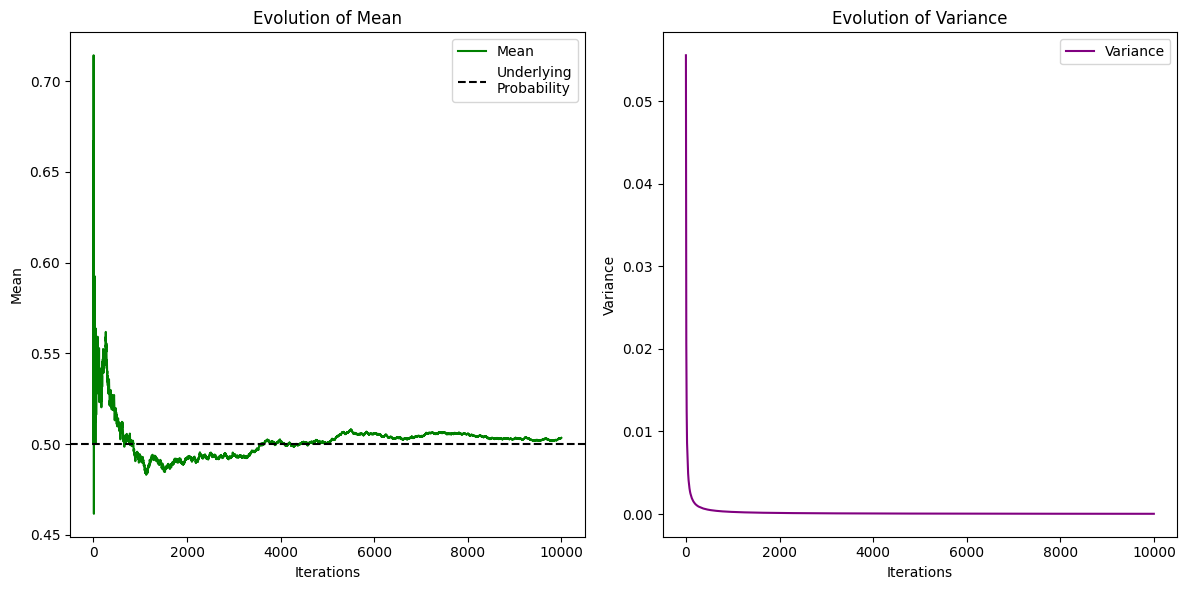

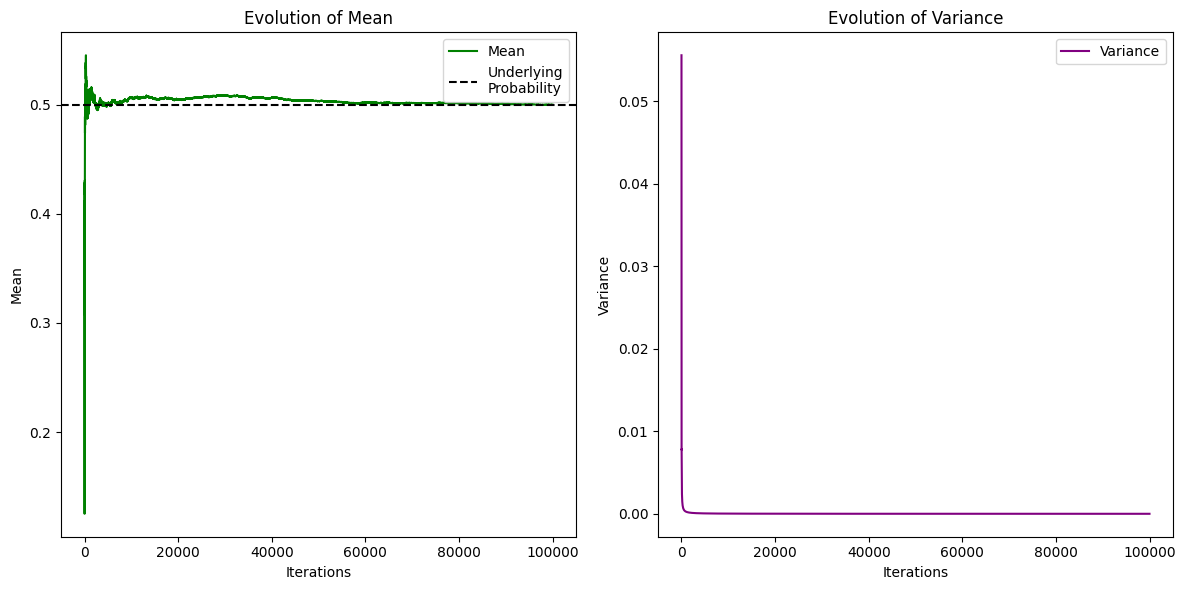

In [19]:
thompson_for_1_bandit(0.5, 100)
thompson_for_1_bandit(0.5, 1000)
thompson_for_1_bandit(0.5, 10000)
thompson_for_1_bandit(0.5, 100000)

### (2c) Thompson sampling for K-armed bandit Problem
For binary outcomes, the Thompson update rule offers an alternative for the UCB-based balancing of exploration and exploitation. Specifically, suppose we have a K-armed bandit problem. The $k$-th arm delivers a reward $r = 1$ with (unknown!) probability $p_{k}$ (and hence $r = 0$ with probability $1 − p_{k}$). For each arm $(k = 1, . . . , K)$, the uncertainty about the corresponding $p_{k}$ is modelled using a Beta-distribution $B(x;\alpha_{k},\beta_{k})$. Thompson sampling now tries to identify the arm that will deliver the maximal cumulative reward (highest $p_{k}$) by proceeding as follows. Initialise all parameters to 1: $\alpha_{k} = 1 = \beta_{k}$; Now repeat the following loop:

**(1)** We use the beta-distributions to simulate the pulling of each arm. This means that we sample a value $U_{k}$ from each of the $K$ Beta-distributions:  
$$
U_{k} \sim B(x;\alpha_{k},\beta_{k}) \quad (k = 1 \dots K)
$$

**(2)** For this simulation, determine which arm gave the best result: 
$$
k_{\operatorname{ max }} \operatorname{ arg max } \{ U_{1},U_{2},\dots,U_{K} \}
$$

**(3)** Mindful of the uncertainties on the $p_{k}$-values, the above simulation gives us reason to believe that pulling the $k_{\operatorname{ max }}$ arm is rational (after all, we did a simulation using the available evidence, and this was the result).

**(4)** Sample the corresponding arm (i.e. arm $k_{\operatorname{ max }}$) and get reward $r$ (either $1$ or $0$);

**(5)** Use the Bayesian update rule for the corresponding parameters:
$$
\begin{align}
\alpha k_{\operatorname{ max }} &\leftarrow \alpha k_{\operatorname{ max }} \\
\beta k_{\operatorname{ max }} &\leftarrow \beta + (1-r) k_{\operatorname{ max }}
\end{align}
$$

**Task 2**: Write code to implement Thompson sampling for the above scenario when $K = 3$.

In [21]:
def thompson_for_k_bandit(probabilities, 
                          n_iterations=10000, 
                          calculate_regret=False):
    # Initializing Arms
    arms = {}

    ##############
    if calculate_regret == True:
        total_regret=[0]
    ##############

    for k, p in enumerate(probabilities, 1):
        BETA_dist = BETA()
        
        arms[k] = {
            "Probability": p,
            "Distribution": BETA_dist,
            "Means": [],
            "Variances": [],
            "Reward": []
        }
    
    # Thompson Sampling Process
    for i in range(n_iterations):
        # Step 1: Sample from each arm's Beta distribution
        samples = {k: np.random.beta(arm["Distribution"].a, arm["Distribution"].b) for k, arm in arms.items()}
        
        # Step 2: Find the arm with the maximum sample
        chosen_arm_key = max(samples, key=samples.get)
        chosen_arm = arms[chosen_arm_key]

        # Step 3: Sample reward from the chosen arm
        reward = np.random.binomial(1, chosen_arm["Probability"])

        # Step 4: Update alpha and beta in the chosen arm's BETA object
        chosen_arm["Distribution"].thomson_update(reward)

        # Step 5: Store updated means and variances
        for k, arm in arms.items():
            arm["Means"].append(arm["Distribution"].mean())
            arm["Variances"].append(arm["Distribution"].variance())

        # Also saving whether an arm has received a reward or not
        for k in arms:
            arms[k]["Reward"].append(k == chosen_arm_key)
        
        ############################
        # Cumulative Regret
        if calculate_regret == True:
            if chosen_arm["Probability"]==max(probabilities):
                total_regret.append(total_regret[-1])
            else:
                regret = max(probabilities)-chosen_arm["Probability"]
                total_regret.append(total_regret[-1]+regret)
        ############################
            
    ############################
    if calculate_regret == True: 
        return arms, total_regret
    ############################
    else:
        return arms

In [22]:
def plot_k_bandit(arms):
    plt.figure(figsize=(14, 6))

    # Plotting the evolution of means for each arm
    plt.subplot(1, 2, 1)
    for arm_key, arm in arms.items():
        plt.plot(arm["Means"], label=f'Arm {arm_key} (p={arm["Probability"]:.2f})')
    plt.title('Evolution of Means')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Probability')
    plt.legend()

    # Plotting the evolution of variances for each arm
    plt.subplot(1, 2, 2)
    for arm_key, arm in arms.items():
        plt.plot(arm["Variances"], label=f'Arm {arm_key} (p={arm["Probability"]:.2f})')
    plt.title('Evolution of Variances')
    plt.xlabel('Iterations')
    plt.ylabel('Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
def get_bandit_results(arms_results):
    for arm_key, arm_data in arms_results.items():
        print(f"Arm {arm_key}:")
        print("------")
        print("Total Number of Rewards Received:", sum(arm_data["Reward"]))
        print("Reward Percentage:", np.mean(arm_data["Reward"]))
        print("Final alpha:", arm_data["Distribution"].a)
        print("Final beta:", arm_data["Distribution"].b)
        print("Final Mean:", arm_data["Distribution"].mean())
        print("Final Variance:", arm_data["Distribution"].variance())
        print("==============================")

Arm 1:
------
Total Number of Rewards Received: 17
Reward Percentage: 0.017
Final alpha: 7
Final beta: 12
Final Mean: 0.3684210526315789
Final Variance: 0.011634349030470914
Arm 2:
------
Total Number of Rewards Received: 30
Reward Percentage: 0.03
Final alpha: 15
Final beta: 17
Final Mean: 0.46875
Final Variance: 0.007546164772727273
Arm 3:
------
Total Number of Rewards Received: 953
Reward Percentage: 0.953
Final alpha: 665
Final beta: 290
Final Mean: 0.6963350785340314
Final Variance: 0.00022118466206802898


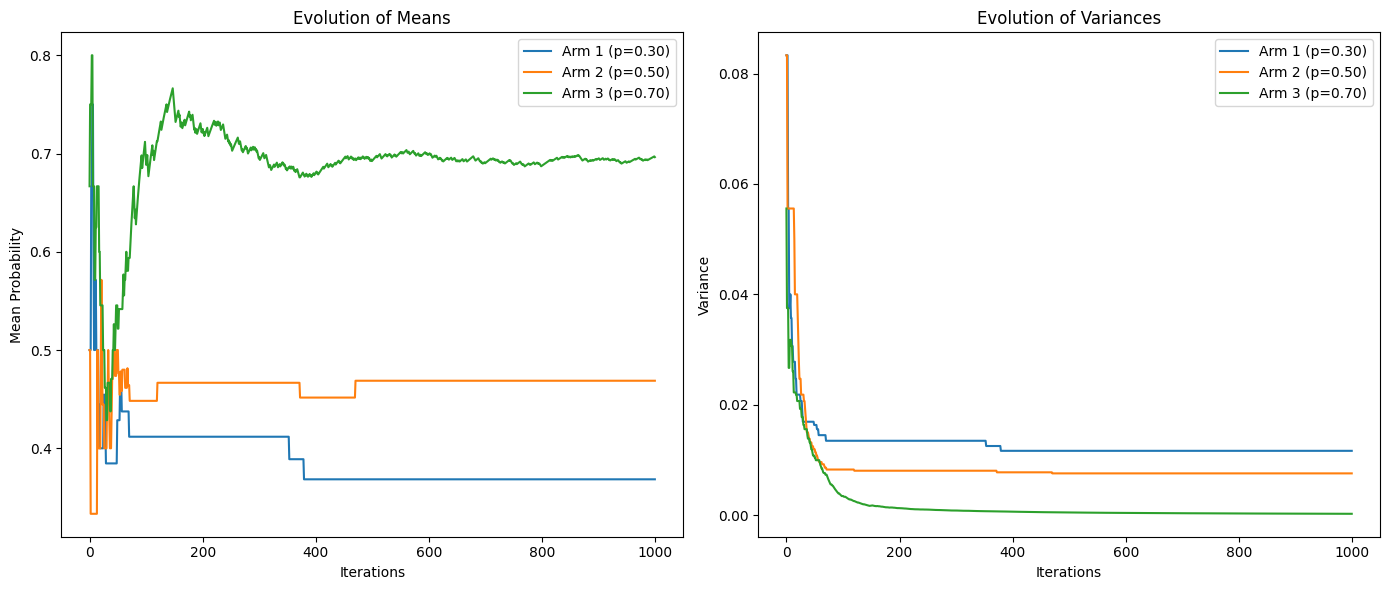

In [ ]:
probabilities = [0.3, 0.5, 0.7]
arms_1 = thompson_for_k_bandit(probabilities, n_iterations=1000)
get_bandit_results(arms_1)
plot_k_bandit(arms_1)

Arm 1:
------
Total Number of Rewards Received: 21
Reward Percentage: 0.0021
Final alpha: 7
Final beta: 16
Final Mean: 0.30434782608695654
Final Variance: 0.008821676118462508
Arm 2:
------
Total Number of Rewards Received: 7
Reward Percentage: 0.0007
Final alpha: 1
Final beta: 8
Final Mean: 0.1111111111111111
Final Variance: 0.009876543209876543
Arm 3:
------
Total Number of Rewards Received: 9972
Reward Percentage: 0.9972
Final alpha: 6975
Final beta: 2999
Final Mean: 0.6993182273912172
Final Variance: 2.107992423354617e-05


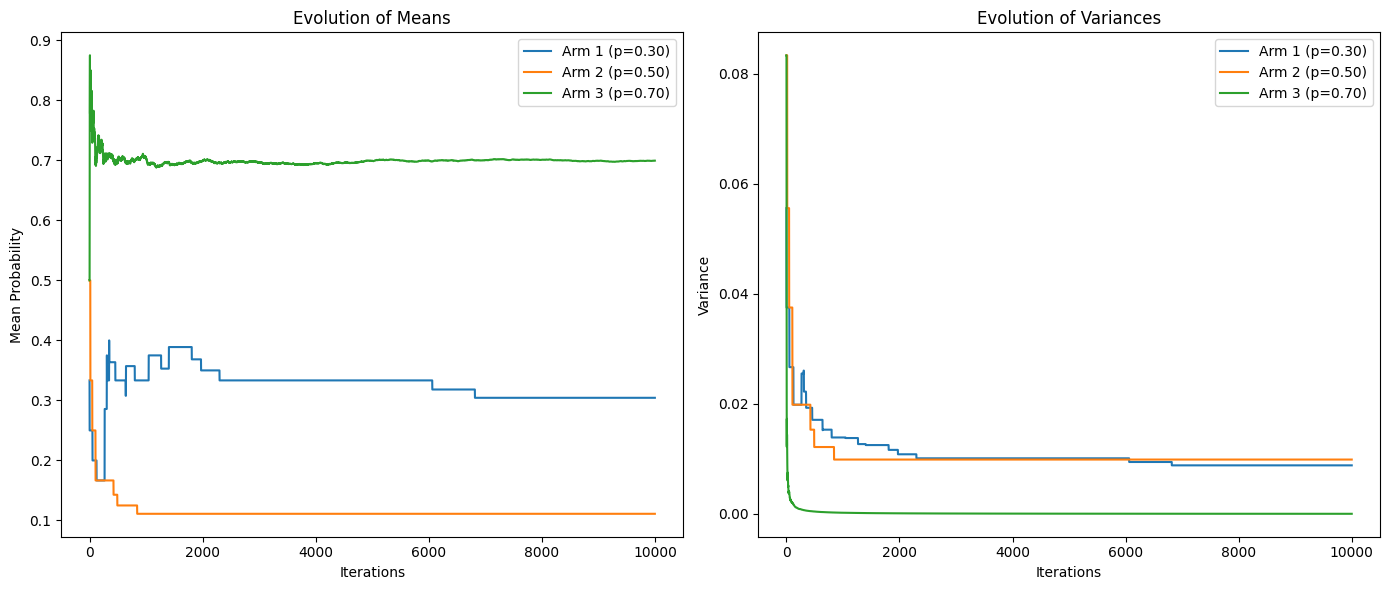

In [25]:
probabilities = [0.3, 0.5, 0.7]
arms_2 = thompson_for_k_bandit(probabilities, n_iterations=10000)
get_bandit_results(arms_2)
plot_k_bandit(arms_2)

Arm 1:
------
Total Number of Rewards Received: 12
Reward Percentage: 0.00012
Final alpha: 2
Final beta: 12
Final Mean: 0.14285714285714285
Final Variance: 0.00816326530612245
Arm 2:
------
Total Number of Rewards Received: 31
Reward Percentage: 0.00031
Final alpha: 12
Final beta: 21
Final Mean: 0.36363636363636365
Final Variance: 0.006806028196402528
Arm 3:
------
Total Number of Rewards Received: 99957
Reward Percentage: 0.99957
Final alpha: 69775
Final beta: 30184
Final Mean: 0.6980361948398843
Final Variance: 2.1086601193811463e-06


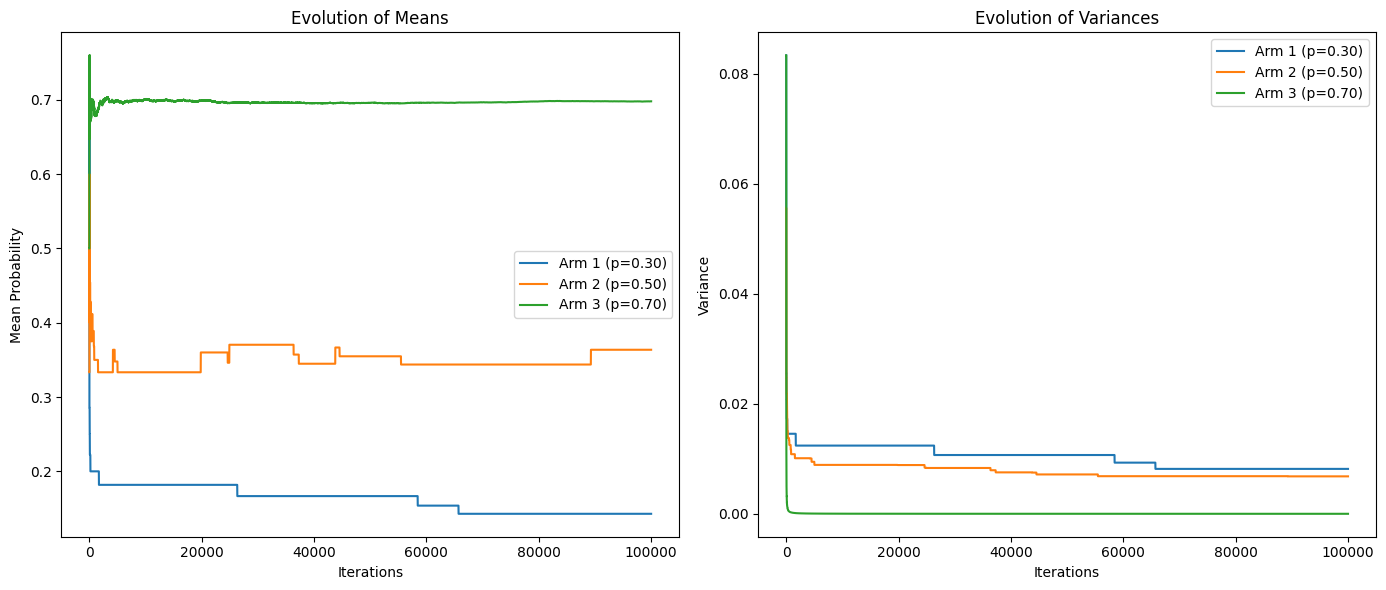

In [26]:
probabilities = [0.3, 0.5, 0.7]
arms_3 = thompson_for_k_bandit(probabilities, n_iterations=100000)
get_bandit_results(arms_3)
plot_k_bandit(arms_3)

We can see that, even with the numbers being close together, the algorithm still performs very well.

Arm 1:
------
Total Number of Rewards Received: 94
Reward Percentage: 0.0094
Final alpha: 37
Final beta: 59
Final Mean: 0.3854166666666667
Final Variance: 0.002441965564146621
Arm 2:
------
Total Number of Rewards Received: 239
Reward Percentage: 0.0239
Final alpha: 114
Final beta: 127
Final Mean: 0.4730290456431535
Final Variance: 0.0010300519323185162
Arm 3:
------
Total Number of Rewards Received: 9667
Reward Percentage: 0.9667
Final alpha: 5344
Final beta: 4325
Final Mean: 0.5526941772675561
Final Variance: 2.556601072203675e-05


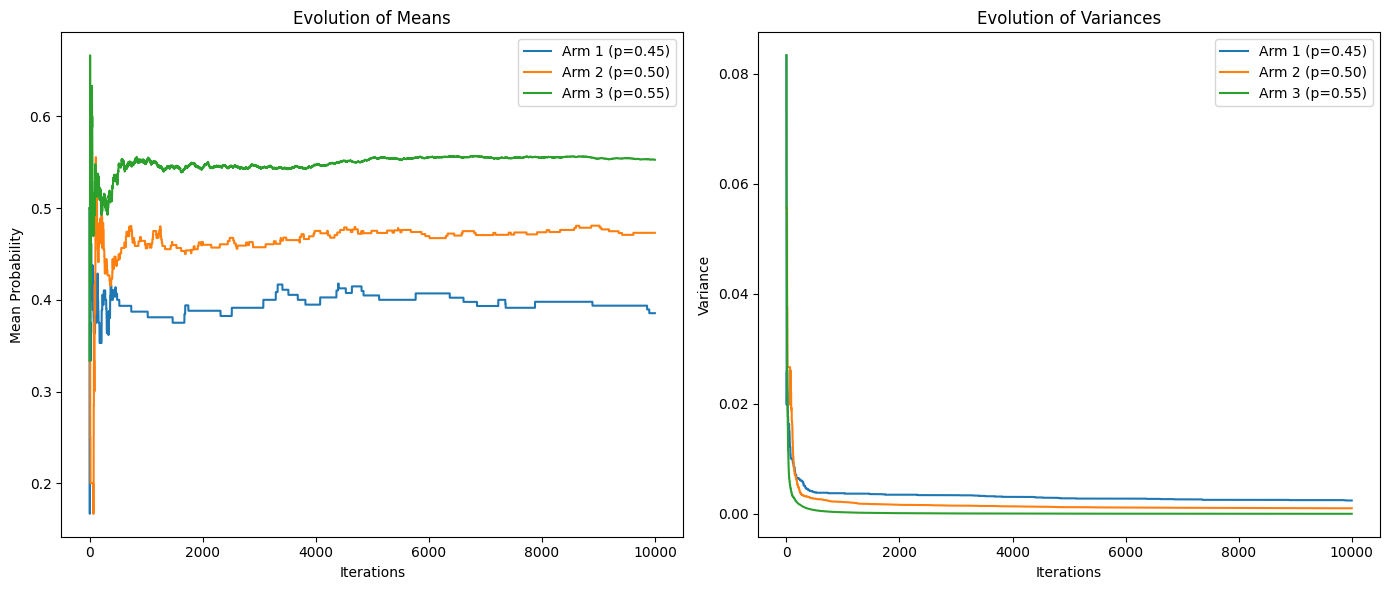

In [ ]:
probabilities = [0.45, 0.5, 0.55]
arms_4 = thompson_for_k_bandit(probabilities, n_iterations=10000)
get_bandit_results(arms_4)
plot_k_bandit(arms_4)

Arm 1:
------
Total Number of Rewards Received: 1572
Reward Percentage: 0.1572
Final alpha: 755
Final beta: 819
Final Mean: 0.47966963151207115
Final Variance: 0.00015846773086802859
Arm 2:
------
Total Number of Rewards Received: 1897
Reward Percentage: 0.1897
Final alpha: 927
Final beta: 972
Final Mean: 0.4881516587677725
Final Variance: 0.0001315050614789709
Arm 3:
------
Total Number of Rewards Received: 6531
Reward Percentage: 0.6531
Final alpha: 3302
Final beta: 3231
Final Mean: 0.505433950711771
Final Variance: 3.825688279456107e-05


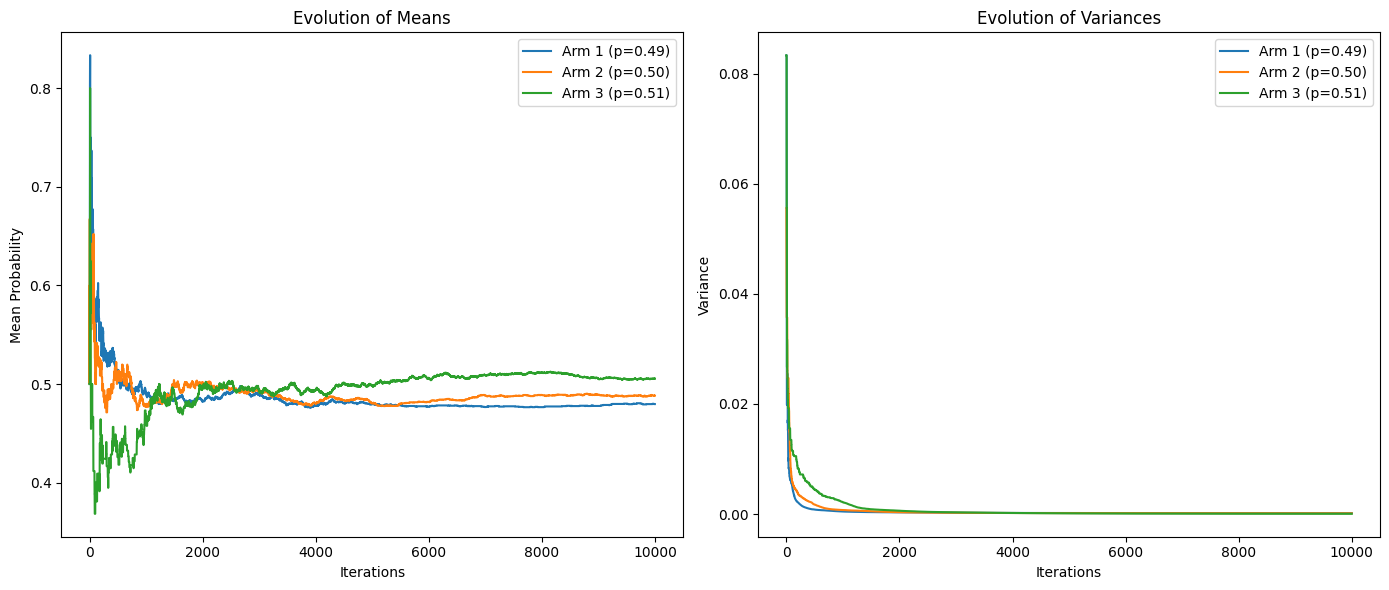

In [ ]:
probabilities = [0.49, 0.5, 0.51]
arms_5 = thompson_for_k_bandit(probabilities, n_iterations=10000)
get_bandit_results(arms_5)
plot_k_bandit(arms_5)

### (2d) Thompson Sampling vs. UCB

**Task 3**: Perform numerical experiments in which you compare Thompson sampling with the UCB. Use *total regret* (provide the precise definition that you’re using) as your performance criteria. For UCB, experiment with different values of the hyperparameter $c$. The fact that, for Thompson sampling, you don’t need to specify an hyperparameter, is a distinct advantage.

In [73]:
class UCBBandit:
    def __init__(self, probabilities, c=1.0):
        self.probabilities = probabilities
        self.c = c 
        self.n_arms = len(probabilities)
        self.counts = [0] * self.n_arms 
        self.values = [0.0] * self.n_arms

    def select_arm(self):
        total_counts = sum(self.counts)
        ucb_values = [0.0] * self.n_arms

        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                # To handle the division by zero issue
                ucb_values[arm] = float('inf')  # Encourage exploring arms not yet tried
            else:
                bonus = self.c * np.sqrt(np.log(total_counts) / self.counts[arm])
                ucb_values[arm] = self.values[arm] + bonus

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # Updating the average reward for the chosen arm
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward
    
    def run(self, n_iterations):
        cumulative_regrets = []
        cumulative_regret = 0
        best_arm_probability = max(self.probabilities)
        
        for i in range(n_iterations):
            chosen_arm = self.select_arm()
            reward = np.random.binomial(1, self.probabilities[chosen_arm])
            self.update(chosen_arm, reward)
            
            # Updating and storing the cumulative regret
            cumulative_regret += best_arm_probability - self.probabilities[chosen_arm]
            cumulative_regrets.append(cumulative_regret)

        return cumulative_regrets

In [71]:
def plot_regrets(series_name_pairs, smooth = False):
    plt.figure(figsize=(12, 6))

    for series, name in series_name_pairs:

        if smooth:
            rewards_series = pd.Series(series)
            series = rewards_series.rolling(window=10).mean()

        # Plot the smoothed rewards for each series
        plt.plot(series, label=name)

    plt.title("Cumulative Regret over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.show()

In [81]:
probabilities = [0.45, 0.5, 0.55]

In [90]:
arms, thompson_regret = thompson_for_k_bandit(
    probabilities, 
    100000, 
    calculate_regret=True)

In [83]:
ucb_c = []
c_values = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6]
for c in c_values:
    ucb_bandit = UCBBandit(probabilities, c=c)
    ucb_regret = ucb_bandit.run(n_iterations=100000)
    ucb_c.append(ucb_regret)

In [70]:
ucb_c[3][-1]

75.20000000000034

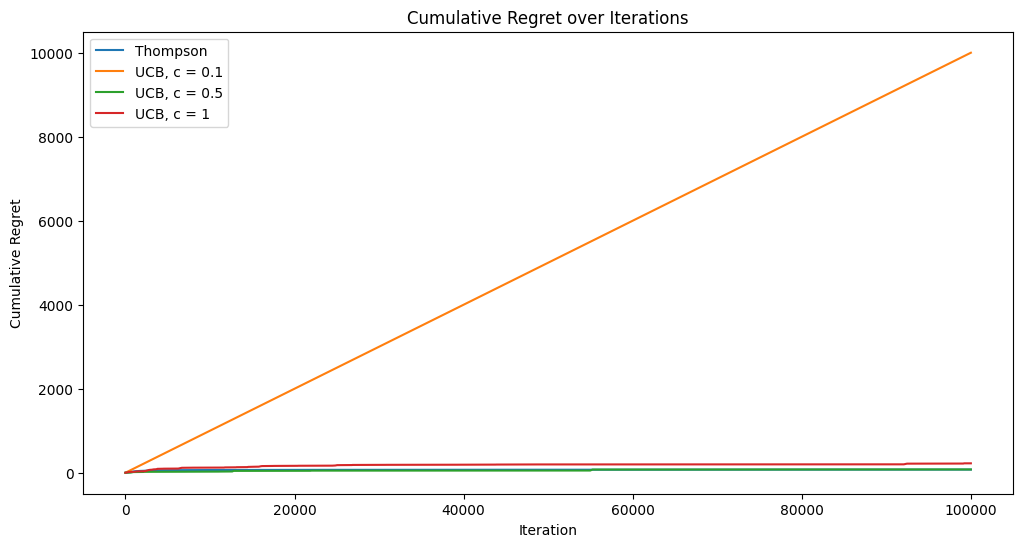

In [91]:
plot_regrets([[thompson_regret, "Thompson"], 
              [ucb_c[1], "UCB, c = 0.1"],
              [ucb_c[2], "UCB, c = 0.5"],
              [ucb_c[3], "UCB, c = 1"]])

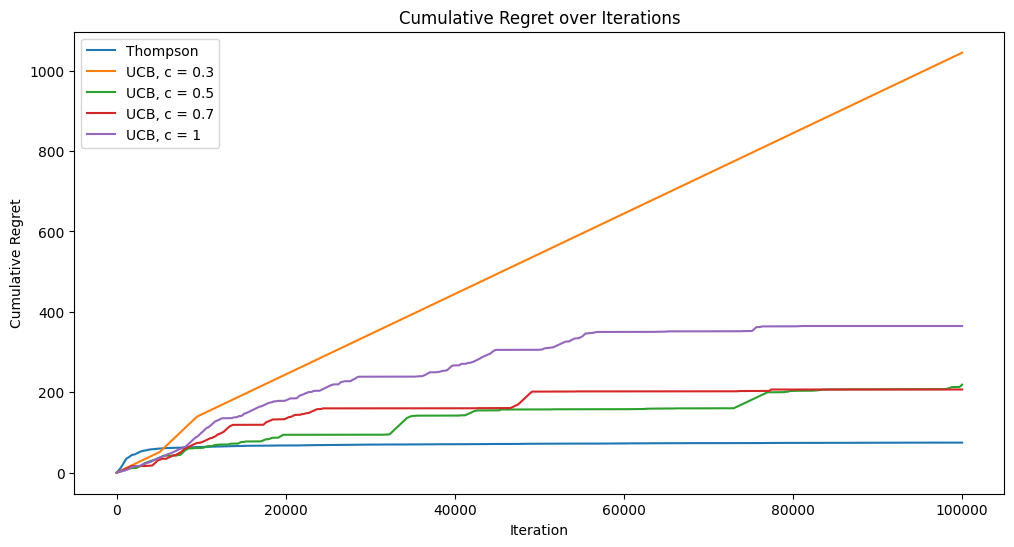

In [110]:
ucb_c = []
probabilities = [0.49, 0.5, 0.51]
c_values = [0.3, 0.5, 0.7, 1]
for c in c_values:
    ucb_bandit = UCBBandit(probabilities, c=c)
    ucb_regret = ucb_bandit.run(n_iterations=100000)
    ucb_c.append(ucb_regret)

plot_regrets([[thompson_regret, "Thompson"], 
              [ucb_c[0], f"UCB, c = {c_values[0]}"],
              [ucb_c[1], f"UCB, c = {c_values[1]}"],
              [ucb_c[2], f"UCB, c = {c_values[2]}"],
              [ucb_c[3], f"UCB, c = {c_values[3]}"]
              ])

In [ ]:
# Example usage
probabilities = [0.3, 0.5, 0.7]  # True probabilities for each arm
ucb_bandit = UCBBandit(probabilities, c=13.0)
ucb_bandit.run(n_iterations=10000)
print("Average rewards:", ucb_bandit.values)
print("Number of times each arm was pulled:", ucb_bandit.counts)

# Example usage
probabilities = [0.3, 0.5, 0.7]  # True probabilities for each arm
ucb_bandit = UCBBandit(probabilities, c=7.0)
cumulative_regrets = ucb_bandit.run(n_iterations=1000)

# Plotting Cumulative Regret Over Time
plt.figure(figsize=(10, 6))
plt.plot(cumulative_regrets, label='Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

In [27]:
probabilities = [0.49, 0.5, 0.51]
arms_regret, total_regret = thompson_for_k_bandit(
    probabilities, 
    n_iterations=10000, 
    calculate_regret = True)


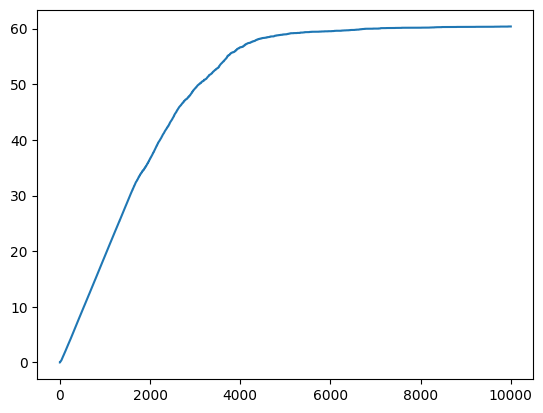

In [29]:
plt.plot(total_regret)

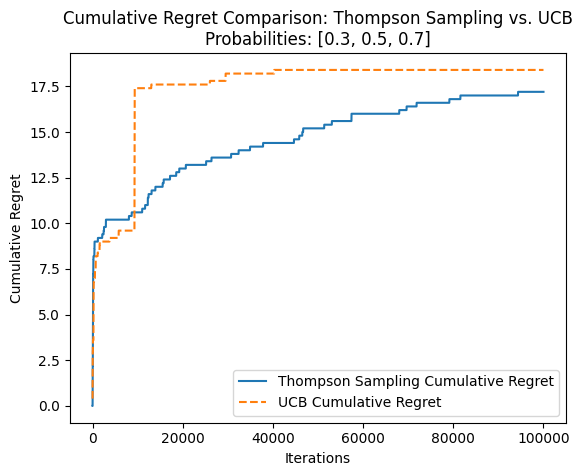

In [40]:
probabilities = [0.3, 0.5, 0.7]  # True probabilities for each arm
arms, thompson_regret = thompson_for_k_bandit(probabilities, 100000, calculate_regret=True)
ucb_bandit = UCBBandit(probabilities, c=0.5)
ucb_regret = ucb_bandit.run(n_iterations=100000)

plt.title(f'Cumulative Regret Comparison: Thompson Sampling vs. UCB\nProbabilities: {probabilities}')
plt.plot(thompson_regret, label='Thompson Sampling Cumulative Regret')
plt.plot(ucb_regret, label='UCB Cumulative Regret', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

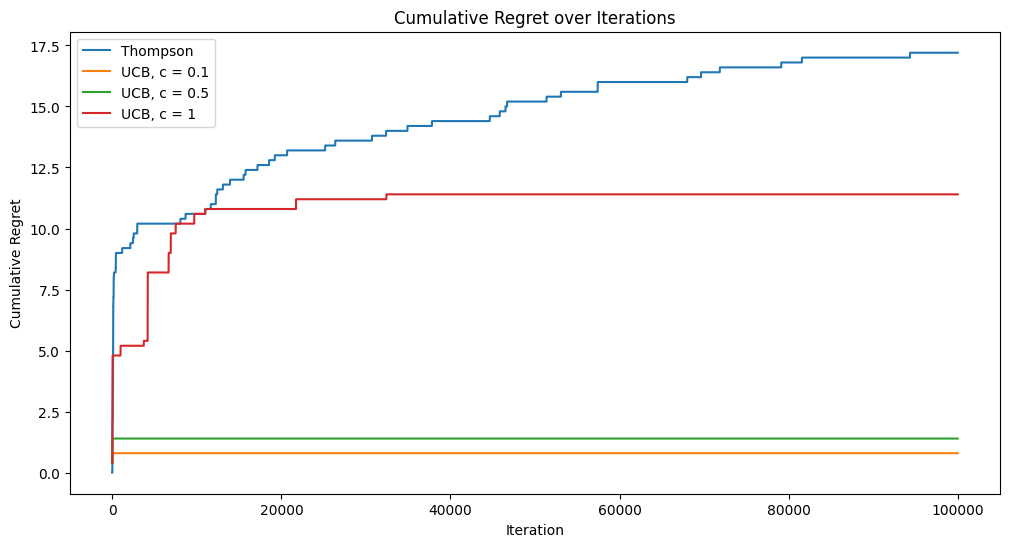

In [55]:
plot_regrets([[thompson_regret, "Thompson"], 
              [ucb_c[0], "UCB, c = 0.1"],
              [ucb_c[1], "UCB, c = 0.5"],
              [ucb_c[2], "UCB, c = 1"]])